# Project: Identify Customer Segments

In this project, we will apply unsupervised learning techniques to identify segments of the population that form the core customer base for a mail-order sales company in Germany. These segments can then be used to direct marketing campaigns towards audiences that will have the highest expected rate of returns. The data that we use has been provided by Udacity and their partners at Bertelsmann Arvato Analytics and represents a real-life data science task. **We use the AZ Direct GmbH data solely to complete the data mining task which is part of the Udacity Unsupervised Learning projects, and we are prohibited from using the AZ Direct GmbH data in any other context**.

In [1]:
# import libraries here; add more as necessary
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# magic word for producing visualizations in notebook
%matplotlib inline


### Step 0: Load the Data

There are four files associated with this project (not including this one):

- `Udacity_AZDIAS_Subset.csv`: Demographics data for the general population of Germany; 891211 persons (rows) x 85 features (columns).
- `Udacity_CUSTOMERS_Subset.csv`: Demographics data for customers of a mail-order company; 191652 persons (rows) x 85 features (columns).
- `Data_Dictionary.md`: Detailed information file about the features in the provided datasets.
- `AZDIAS_Feature_Summary.csv`: Summary of feature attributes for demographics data; 85 features (rows) x 4 columns

Each row of the demographics files represents a single person, but also includes information outside of individuals, including information about their household, building, and neighborhood. We will use this information to cluster the general population into groups with similar demographic properties. Then, we will see how the people in the customers dataset fit into those created clusters. The hope here is that certain clusters are over-represented in the customers data, as compared to the general population; those over-represented clusters will be assumed to be part of the core userbase. This information can then be used for further applications, such as targeting for a marketing campaign.

To start off with, load in the demographics data for the general population into a pandas DataFrame, and do the same for the feature attributes summary. Note for all of the `.csv` data files in this project: they're semicolon (`;`) delimited, so we'll need an additional argument in our [`read_csv()`](https://pandas.pydata.org/pandas-docs/stable/generated/pandas.read_csv.html) call to read in the data properly. Also, considering the size of the main dataset, it may take some time for it to load completely.

Once the dataset is loaded, it's recommended that we take a little bit of time just browsing the general structure of the dataset and feature summary file. We'll be getting deep into the innards of the cleaning in the first major step of the project, so gaining some general familiarity can help us get our bearings.

In [2]:
# Load in the general demographics data.
azdias = pd.read_csv('Udacity_AZDIAS_Subset.csv', sep=';'  , engine='python')

# Load in the feature summary file.
feat_info = pd.read_csv('AZDIAS_Feature_Summary.csv', sep=';'  , engine='python')

# Check the structure of the data after it's loaded (e.g. print the number of
# rows and columns, print the first few rows).
azdias.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,-1,2,1,2.0,3,4,3,5,5,3,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,-1,1,2,5.0,1,5,2,5,4,5,...,2.0,3.0,2.0,1.0,1.0,5.0,4.0,3.0,5.0,4.0
2,-1,3,2,3.0,1,4,1,2,3,5,...,3.0,3.0,1.0,0.0,1.0,4.0,4.0,3.0,5.0,2.0
3,2,4,2,2.0,4,2,5,2,1,2,...,2.0,2.0,2.0,0.0,1.0,3.0,4.0,2.0,3.0,3.0
4,-1,3,1,5.0,4,3,4,1,3,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,4.0,6.0,5.0


## Step 1: Preprocessing

### Step 1.1: Assess Missing Data

The feature summary file contains a summary of properties for each demographics data column. We will use this file to help us make cleaning decisions during this stage of the project. First of all, we should assess the demographics data in terms of missing data.

#### Step 1.1.1: Convert Missing Value Codes to NaNs
The fourth column of the feature attributes summary (loaded in above as `feat_info`) documents the codes from the data dictionary that indicate missing or unknown data. While the file encodes this as a list (e.g. `[-1,0]`), this will get read in as a string object. We'll need to do a little bit of parsing to make use of it to identify and clean the data. Convert data that matches a 'missing' or 'unknown' value code into a numpy NaN value. We might want to see how much data takes on a 'missing' or 'unknown' code, and how much data is naturally missing, as a point of interest.

In [3]:
feat_info.head()

,attribute,information_level,type,missing_or_unknown
0,AGER_TYP,person,categorical,"[-1,0]"
1,ALTERSKATEGORIE_GROB,person,ordinal,"[-1,0,9]"
2,ANREDE_KZ,person,categorical,"[-1,0]"
3,CJT_GESAMTTYP,person,categorical,[0]
4,FINANZ_MINIMALIST,person,ordinal,[-1]


In [4]:
# unique missing values
feat_info['missing_or_unknown'].unique()

array(['[-1,0]', '[-1,0,9]', '[0]', '[-1]', '[]', '[-1,9]', '[-1,X]',
       '[XX]', '[-1,XX]'], dtype=object)

In [5]:
# Identify missing or unknown data values and convert them to NaNs.

for row in range(feat_info.shape[0]):
    missing_value = []
    for element in (feat_info.iloc[row][3].strip(']').strip('[').split(sep=',')):
        if element == '-1' or  element == '0' or element == '9':
            missing_value.append(int(element))
        else:
            missing_value.append(element)    
    azdias[feat_info.iloc[row][0]].replace(missing_value, np.nan, inplace = True)

In [6]:
azdias.isnull().sum().sum()

8373929

#### Step 1.1.2: Assess Missing Data in Each Column

How much missing data is present in each column? There are a few columns that are outliers in terms of the proportion of values that are missing. We will want to use matplotlib's [`hist()`](https://matplotlib.org/api/_as_gen/matplotlib.pyplot.hist.html) function to visualize the distribution of missing value counts to find these columns.

In [7]:
# Perform an assessment of how much missing data there is in each column of the
# dataset.
azdias.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891221 entries, 0 to 891220
Data columns (total 85 columns):
AGER_TYP                 205378 non-null float64
ALTERSKATEGORIE_GROB     888340 non-null float64
ANREDE_KZ                891221 non-null int64
CJT_GESAMTTYP            886367 non-null float64
FINANZ_MINIMALIST        891221 non-null int64
FINANZ_SPARER            891221 non-null int64
FINANZ_VORSORGER         891221 non-null int64
FINANZ_ANLEGER           891221 non-null int64
FINANZ_UNAUFFAELLIGER    891221 non-null int64
FINANZ_HAUSBAUER         891221 non-null int64
FINANZTYP                891221 non-null int64
GEBURTSJAHR              498903 non-null float64
GFK_URLAUBERTYP          886367 non-null float64
GREEN_AVANTGARDE         891221 non-null int64
HEALTH_TYP               780025 non-null float64
LP_LEBENSPHASE_FEIN      793589 non-null float64
LP_LEBENSPHASE_GROB      796649 non-null float64
LP_FAMILIE_FEIN          813429 non-null float64
LP_FAMILIE_GROB          

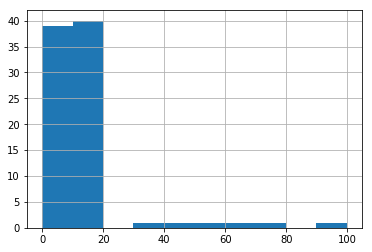

In [8]:
# histogram of percentage of columns with null value 
(100 * azdias.isnull().sum() / azdias['CJT_GESAMTTYP'].shape[0]).hist();

In [9]:
# columns with null values greater than 20%

azdias_columns = azdias.columns.tolist()
high_null_column = []

for column in range(len(azdias_columns)):
    column_name = azdias.columns[column]
    null_value = (azdias.isnull().sum() / len(azdias))[column_name]
    if null_value > 0.20:
        high_null_column.append(column_name)
        
high_null_column  

['AGER_TYP',
 'GEBURTSJAHR',
 'TITEL_KZ',
 'ALTER_HH',
 'KK_KUNDENTYP',
 'KBA05_BAUMAX']

In [10]:
# Remove the outlier columns from the dataset.

azdias.drop(high_null_column, axis =1, inplace = True) 

#### Discussion 1.1.2: Assess Missing Data in Each Column

Columns with null values greater than 20% are outliers as we saw in the histogram, so I decided to remove them.

#### Step 1.1.3: Assess Missing Data in Each Row

Now, we'll perform a similar assessment for the rows of the dataset. How much data is missing in each row? As with the columns, we should see some groups of points that have a very different numbers of missing values. Divide the data into two subsets: one for data points that are above some threshold for missing values, and a second subset for points below that threshold.

In order to know what to do with the outlier rows, we should see if the distribution of data values on columns that are not missing data (or are missing very little data) are similar or different between the two groups.

In [11]:
# How much data is missing in each row of the dataset?

azdias.isnull().sum(axis = 1)

0         43
1          0
2          0
3          7
4          0
5          0
6          0
7          0
8          0
9          0
10         0
11        47
12         6
13         8
14        47
15         8
16         6
17        47
18         3
19         0
20        10
21         0
22         0
23         8
24        47
25         5
26        19
27         0
28         0
29         2
          ..
891191     0
891192     0
891193     0
891194     0
891195     0
891196     0
891197     0
891198     0
891199     0
891200     0
891201     0
891202     0
891203    14
891204     0
891205     0
891206     0
891207     0
891208     3
891209     0
891210     0
891211     0
891212     0
891213     0
891214     0
891215     0
891216     3
891217     4
891218     5
891219     0
891220     0
Length: 891221, dtype: int64

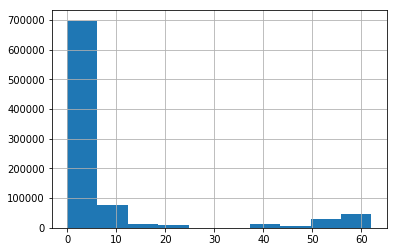

In [12]:
# histogram for percentage of missing values in each row

(100 * azdias.isnull().sum(axis = 1) / azdias.shape[1]).hist();

Taking a threshold of 20% is very appealing to me to remove the outlier rows.

In [13]:
# Divide the data into two subsets:
# one for data points that are above threshold(20%) for missing values, 
# and a second subset for points below that threshold.

missing_above_threshold = azdias[azdias.isnull().sum(axis = 1) / azdias.shape[1] > 0.2]

missing_below_threshold = azdias[azdias.isnull().sum(axis = 1) / azdias.shape[1] <= 0.2]

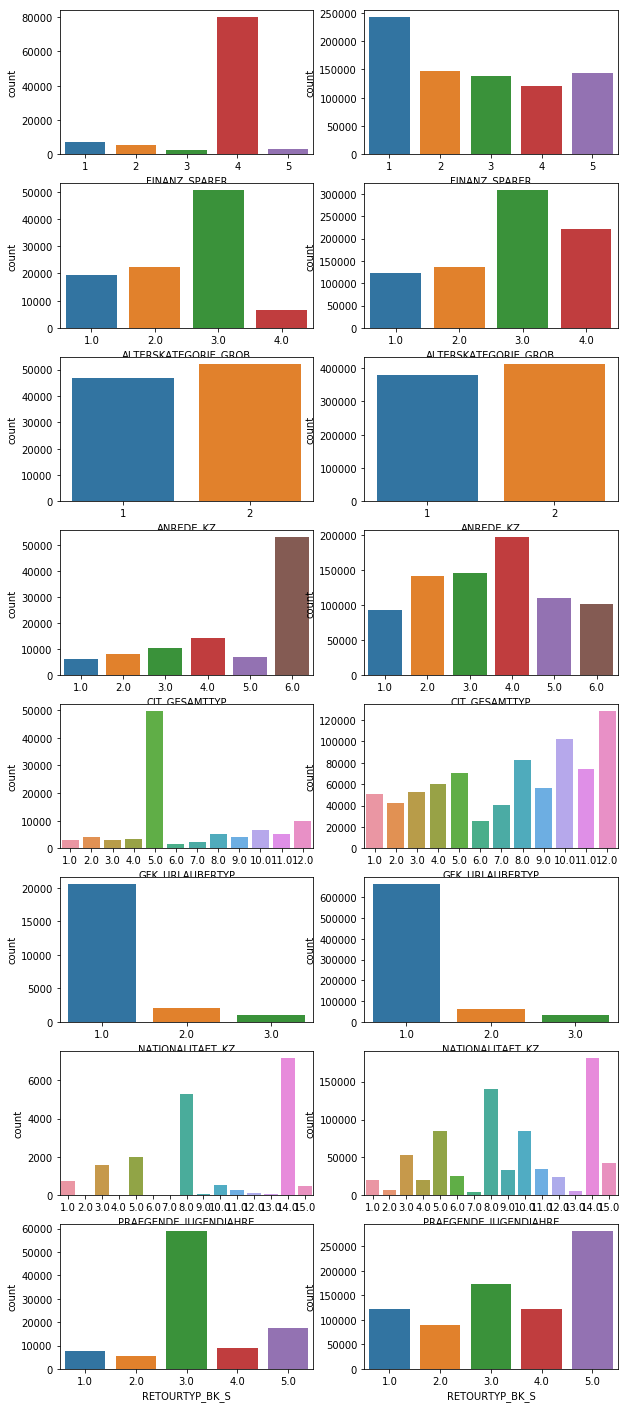

In [14]:
# the distribution of data points that are above the threshold vs below that threshold for some variables

plt.figure(figsize= (10, 25))

plt.subplot(8, 2, 1)
sns.countplot(data = missing_above_threshold, x = 'FINANZ_SPARER') 
plt.subplot(8, 2, 3)
sns.countplot(data = missing_above_threshold, x = 'ALTERSKATEGORIE_GROB') 
plt.subplot(8, 2, 5)
sns.countplot(data = missing_above_threshold, x = 'ANREDE_KZ') 
plt.subplot(8, 2, 7)
sns.countplot(data = missing_above_threshold, x = 'CJT_GESAMTTYP') 
plt.subplot(8, 2, 9)
sns.countplot(data = missing_above_threshold, x = 'GFK_URLAUBERTYP') 
plt.subplot(8, 2, 11)
sns.countplot(data = missing_above_threshold, x = 'NATIONALITAET_KZ') 
plt.subplot(8, 2, 13)
sns.countplot(data = missing_above_threshold, x = 'PRAEGENDE_JUGENDJAHRE') 
plt.subplot(8, 2, 15)
sns.countplot(data = missing_above_threshold, x = 'RETOURTYP_BK_S') 


plt.subplot(8, 2, 2)
sns.countplot(data = missing_below_threshold, x = 'FINANZ_SPARER')
plt.subplot(8, 2, 4)
sns.countplot(data = missing_below_threshold, x = 'ALTERSKATEGORIE_GROB') 
plt.subplot(8, 2, 6)
sns.countplot(data = missing_below_threshold, x = 'ANREDE_KZ') 
plt.subplot(8, 2, 8)
sns.countplot(data = missing_below_threshold, x = 'CJT_GESAMTTYP') 
plt.subplot(8, 2, 10)
sns.countplot(data = missing_below_threshold, x = 'GFK_URLAUBERTYP') 
plt.subplot(8, 2, 12)
sns.countplot(data = missing_below_threshold, x = 'NATIONALITAET_KZ') 
plt.subplot(8, 2, 14)
sns.countplot(data = missing_below_threshold, x = 'PRAEGENDE_JUGENDJAHRE') 
plt.subplot(8, 2, 16)
sns.countplot(data = missing_below_threshold, x = 'RETOURTYP_BK_S') 

plt.show() 

#### Discussion 1.1.3: Assess Missing Data in Each Row

Are the data with lots of missing values are qualitatively different from data with few or no missing values?

From the plots we can see That data with many missing values looks very different from the data with few or no missing values, so, we could use this many missing values data later on.

### Step 1.2: Select and Re-Encode Features

Checking for missing data isn't the only way in which we can prepare a dataset for analysis. Since the unsupervised learning techniques to be used will only work on data that is encoded numerically, we need to make a few encoding changes or additional assumptions to be able to make progress. In addition, while almost all of the values in the dataset are encoded using numbers, not all of them represent numeric values. Check the third column of the feature summary (`feat_info`) for a summary of types of measurement.

In [15]:
# unique types of variables
feat_info['type'].unique()

array(['categorical', 'ordinal', 'numeric', 'mixed', 'interval'], dtype=object)

In [16]:
# How many features are there of each data type?

print('categorical features:', feat_info.query('type == "categorical"').shape[0])
print('mixed features:', feat_info.query('type == "mixed"').shape[0])
print('ordinal features:', feat_info.query('type == "ordinal"').shape[0])
print('numeric features:', feat_info.query('type == "numeric"').shape[0])
print('interval features:', feat_info.query('type == "interval"').shape[0])

categorical features: 21
mixed features: 7
ordinal features: 49
numeric features: 7
interval features: 1


In the first two parts of this sub-step, we will perform an investigation of the categorical and mixed-type features and make a decision on each of them, whether we will keep, drop, or re-encode each. Then, in the last part, we will create a new data frame with only the selected and engineered columns.

#### Step 1.2.1: Re-Encode Categorical Features

For categorical data, we would ordinarily need to encode the levels as dummy variables.

In [17]:
# Getting categorical features after removing missing values from dataset

dataset_features_list = missing_below_threshold.columns.tolist()
categorical_features_list = feat_info.query('type == "categorical"')['attribute'].tolist()
dataset_categorical_features_list = list(set(dataset_features_list) & set(categorical_features_list))
categorical_features_only = missing_below_threshold[dataset_categorical_features_list]
categorical_features_only.head()

,LP_STATUS_GROB,ANREDE_KZ,OST_WEST_KZ,ZABEOTYP,CJT_GESAMTTYP,NATIONALITAET_KZ,SOHO_KZ,LP_FAMILIE_FEIN,GEBAEUDETYP,LP_STATUS_FEIN,LP_FAMILIE_GROB,FINANZTYP,SHOPPER_TYP,GFK_URLAUBERTYP,GREEN_AVANTGARDE,CAMEO_DEUG_2015,VERS_TYP,CAMEO_DEU_2015
1,1.0,2,W,5,5.0,1.0,1.0,5.0,8.0,2.0,3.0,1,3.0,10.0,0,8,2.0,8A
2,2.0,2,W,5,3.0,1.0,0.0,1.0,1.0,3.0,1.0,1,2.0,10.0,1,4,1.0,4C
3,4.0,2,W,3,2.0,1.0,0.0,NaN,1.0,9.0,NaN,6,1.0,1.0,0,2,1.0,2A
4,2.0,1,W,4,5.0,1.0,0.0,10.0,1.0,3.0,5.0,5,2.0,5.0,0,6,2.0,6B
5,2.0,2,W,4,2.0,1.0,0.0,1.0,1.0,4.0,1.0,2,0.0,1.0,0,8,2.0,8C


In [18]:
# changing datatypes to float
missing_below_threshold['CAMEO_INTL_2015'] = missing_below_threshold['CAMEO_INTL_2015'].astype('float')
missing_below_threshold['CAMEO_DEUG_2015'] = missing_below_threshold['CAMEO_DEUG_2015'].astype('float')

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [19]:
# create a dummy variable for 'OST_WEST_KZ'

missing_below_threshold = pd.get_dummies(missing_below_threshold, columns= ['OST_WEST_KZ'])

In [20]:
# dropping CAMEO_DEU_2015 column that has 44 categories

missing_below_threshold.drop(['CAMEO_DEU_2015'], axis =1,inplace = True)


#### Discussion 1.2.1: Re-Encode Categorical Features

- For binary (two-level) categoricals that take numeric values, I kept them without any change.
- For the one binary variable that takes on non-numeric values, I decided to create a dummy variable using pandas.
- For multi-level categoricals, I choose to encode all the variables using multiple dummy variables except 'CAMEO_DEU_2015' due to its role in increasing the dimensions by another 44 columns if it is encoded with multiple dummy variables.

#### Step 1.2.2: Engineer Mixed-Type Features

There are a handful of features that are marked as "mixed" in the feature summary that require special treatment in order to be included in the analysis. There are two in particular that deserve attention.
- "PRAEGENDE_JUGENDJAHRE" combines information on three dimensions: generation by decade, movement (mainstream vs. avantgarde), and nation (east vs. west). While there aren't enough levels to disentangle east from west, we should create two new variables to capture the other two dimensions: an interval-type variable for decade, and a binary variable for movement.
- "CAMEO_INTL_2015" combines information on two axes: wealth and life stage. Break up the two-digit codes by their 'tens'-place and 'ones'-place digits into two new ordinal variables (which, for the purposes of this project, is equivalent to just treating them as their raw numeric values).

In [21]:
# viewing mixed features only

dataset_features_list = missing_below_threshold.columns.tolist()
mixed_features_list = feat_info.query('type == "mixed"')['attribute'].tolist()
dataset_mixed_features_list = list(set(dataset_features_list) & set(mixed_features_list))
mixed_features_only = missing_below_threshold[dataset_mixed_features_list]
mixed_features_only.head()

,PRAEGENDE_JUGENDJAHRE,LP_LEBENSPHASE_FEIN,PLZ8_BAUMAX,WOHNLAGE,LP_LEBENSPHASE_GROB,CAMEO_INTL_2015
1,14.0,21.0,1.0,4.0,6.0,51.0
2,15.0,3.0,1.0,2.0,1.0,24.0
3,8.0,NaN,1.0,7.0,NaN,12.0
4,8.0,32.0,2.0,3.0,10.0,43.0
5,3.0,8.0,1.0,7.0,2.0,54.0


In [22]:
# Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

missing_below_threshold['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = missing_below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 'Mainstream' if x == 1.0 or x == 3.0 or x == 5.0 or x == 8.0 or x == 10.0 or x == 12.0 or x == 14.0 
                                                                                             else 'Avantgarde' if x == 2.0 or x == 4.0 or x == 6.0 or x == 7.0 or x == 9.0 or x == 11.0 or x == 13.0 or x == 15.0 
                                                                                             else np.nan)

missing_below_threshold['PRAEGENDE_JUGENDJAHRE_DECADE'] = missing_below_threshold['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 4.0 if x == 1.0 or x == 2.0
                                                                                           else 5.0 if x == 3.0 or x == 4.0 
                                                                                           else 6.0 if x == 5.0 or x == 6.0 or x == 7.0 
                                                                                           else 7.0 if x == 8.0 or x == 9.0 
                                                                                           else 8.0 if x == 10.0 or x == 11.0 or x == 12.0 or x == 13.0 
                                                                                           else 9.0 if x == 14.0 or x == 15.0 
                                                                                           else np.nan)

In [23]:
# Investigate "CAMEO_INTL_2015" and engineer the two new variables.

missing_below_threshold['CAMEO_INTL_2015_WEALTH'] = missing_below_threshold['CAMEO_INTL_2015'].apply(lambda x: 1 if x == 11 or x == 12 or x == 13 or x == 14 or x == 15 
                                                                             else 2 if x == 21 or x == 22 or x == 23 or x == 24 or x == 25 
                                                                             else 3 if x == 31 or x == 32 or x == 33 or x == 34 or x == 35 
                                                                             else 4 if x == 41 or x == 42 or x == 43 or x == 44 or x == 45 
                                                                             else 5 if x == 51 or x == 52 or x == 53 or x == 54 or x == 55 
                                                                             else np.nan)

missing_below_threshold['CAMEO_INTL_2015_LIFE_STAGE'] = missing_below_threshold['CAMEO_INTL_2015'].apply(lambda x: 1 if x == 11 or x == 21 or x == 31 or x == 41 or x == 51 
                                                                                 else 2 if x == 12 or x == 22 or x == 32 or x == 42 or x == 52
                                                                                 else 3 if x == 13 or x == 23 or x == 33 or x == 43 or x == 53 
                                                                                 else 4 if x == 14 or x == 24 or x == 34 or x == 44 or x == 54 
                                                                                 else 5 if x == 15 or x == 25 or x == 35 or x == 45 or x == 55
                                                                                 else np.nan)

In [24]:
# dropping 'CAMEO_INTL_2015' and 'PRAEGENDE_JUGENDJAHRE' after engineering the two variables

missing_below_threshold.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)

# drop other mixed features
missing_below_threshold.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 'WOHNLAGE'], axis = 1, inplace = True)

In [25]:
# getting multiple dummy variables after engineer the variables

general_population_data = pd.get_dummies(missing_below_threshold, columns= ['PRAEGENDE_JUGENDJAHRE_MOVEMENT'])

In [26]:
# filling null values with the mode of the column

column_list = general_population_data.columns.tolist()
for column in column_list:
    general_population_data[column].fillna(general_population_data[column].mode()[0],inplace = True)
    

In [27]:
general_population_data.isnull().sum().sum()

0

#### Discussion 1.2.2: Engineer Mixed-Type Features

- For "PRAEGENDE_JUGENDJAHRE" I created two new variables to capture MOVEMENT and DECADE.
- By the same way for "CAMEO_INTL_2015" I created two new variables to capture WEALTH and LIFE STAGE.



#### Step 1.2.3: Complete Feature Selection

In order to finish this step up, we need to make sure that our data frame now only has the columns that we want to keep. To summarize, the dataframe should consist of the following:
- All numeric, interval, and ordinal type columns from the original dataset.
- Binary categorical features (all numerically-encoded).
- Engineered features from other multi-level categorical features and mixed features.

### Step 1.3: Create a Cleaning Function

Even though we've finished cleaning up the general population demographics data, it's important to look ahead to the future and realize that we'll need to perform the same cleaning steps on the customer demographics data. In this substep, complete the function below to execute the main feature selection, encoding, and re-engineering steps we performed above. Then, when it comes to looking at the customer data in Step 3, we can just run this function on that DataFrame to get the trimmed dataset in a single step.

In [28]:

def clean_data(df, high_null_column):
    """
    Perform feature trimming, re-encoding, and engineering for demographics
    data
    
    INPUT: dataframe and a list of high null values names 
    OUTPUT: cleaned dataFrame and a list of dataframe column names
    """  
    # Identify missing or unknown data values and convert them to NaNs.

    for row in range(feat_info.shape[0]):
        missing_value = []
        for element in (feat_info.iloc[row][3].strip(']').strip('[').split(sep=',')):
            if element == '-1' or  element == '0' or element == '9':
                missing_value.append(int(element))
            else:
                missing_value.append(element)    
        df[feat_info.iloc[row][0]].replace(missing_value, np.nan, inplace = True)
    
    df.drop(high_null_column, axis =1, inplace = True)   

    df = df[df.isnull().sum(axis = 1) / df.shape[1] <= 0.2]

    df['CAMEO_INTL_2015'] = df['CAMEO_INTL_2015'].astype('float')
    df['CAMEO_DEUG_2015'] = df['CAMEO_DEUG_2015'].astype('float')
    
    df = pd.get_dummies(df, columns= ['OST_WEST_KZ'])
    
    # dropping cat_morethan_5 categorial columns more than 5 categories

    #df.drop(['CJT_GESAMTTYP','FINANZTYP','GFK_URLAUBERTYP','LP_FAMILIE_FEIN','LP_STATUS_FEIN','ZABEOTYP','GEBAEUDETYP','CAMEO_DEUG_2015','CAMEO_DEU_2015'], axis =1,inplace = True)
    df.drop(['CAMEO_DEU_2015'], axis =1,inplace = True)

    # Investigate "PRAEGENDE_JUGENDJAHRE" and engineer two new variables.

    df['PRAEGENDE_JUGENDJAHRE_MOVEMENT'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 'Mainstream' if x == 1.0 or x == 3.0 or x == 5.0 or x == 8.0 or x == 10.0 or x == 12.0 or x == 14.0 
                                                       else 'Avantgarde' if x == 2.0 or x == 4.0 or x == 6.0 or x == 7.0 or x == 9.0 or x == 11.0 or x == 13.0 or x == 15.0 
                                                       else np.nan)
    
    df['PRAEGENDE_JUGENDJAHRE_DECADE'] = df['PRAEGENDE_JUGENDJAHRE'].apply(lambda x: 4.0 if x == 1.0 or x == 2.0
                                                     else 5.0 if x == 3.0 or x == 4.0 
                                                     else 6.0 if x == 5.0 or x == 6.0 or x == 7.0 
                                                     else 7.0 if x == 8.0 or x == 9.0 
                                                     else 8.0 if x == 10.0 or x == 11.0 or x == 12.0 or x == 13.0 
                                                     else 9.0 if x == 14.0 or x == 15.0 
                                                     else np.nan)

    # Investigate "CAMEO_INTL_2015" and engineer two new variables.

    df['CAMEO_INTL_2015_WEALTH'] = df['CAMEO_INTL_2015'].apply(lambda x: 1 if x == 11 or x == 12 or x == 13 or x == 14 or x == 15 
                                                                             else 2 if x == 21 or x == 22 or x == 23 or x == 24 or x == 25 
                                                                             else 3 if x == 31 or x == 32 or x == 33 or x == 34 or x == 35 
                                                                             else 4 if x == 41 or x == 42 or x == 43 or x == 44 or x == 45 
                                                                             else 5 if x == 51 or x == 52 or x == 53 or x == 54 or x == 55 
                                                                             else np.nan)
    
    df['CAMEO_INTL_2015_LIFE_STAGE'] = df['CAMEO_INTL_2015'].apply(lambda x: 1 if x == 11 or x == 21 or x == 31 or x == 41 or x == 51 
                                                                                 else 2 if x == 12 or x == 22 or x == 32 or x == 42 or x == 52
                                                                                 else 3 if x == 13 or x == 23 or x == 33 or x == 43 or x == 53 
                                                                                 else 4 if x == 14 or x == 24 or x == 34 or x == 44 or x == 54 
                                                                                 else 5 if x == 15 or x == 25 or x == 35 or x == 45 or x == 55
                                                                                 else np.nan)
    
    df.drop(['CAMEO_INTL_2015', 'PRAEGENDE_JUGENDJAHRE'], axis = 1, inplace = True)
    
    # drop other mixed features
    df.drop(['PLZ8_BAUMAX', 'LP_LEBENSPHASE_FEIN','LP_LEBENSPHASE_GROB', 'WOHNLAGE'], axis = 1, inplace = True)

    df = pd.get_dummies(df, columns= ['PRAEGENDE_JUGENDJAHRE_MOVEMENT'])
    
    # filling null values with the mode of the column
    customer_column_list = df.columns.tolist()
    for column in customer_column_list:
        df[column].fillna(df[column].mode()[0],inplace = True)
        
    return df, customer_column_list

## Step 2: Feature Transformation

### Step 2.1: Apply Feature Scaling

Before we apply dimensionality reduction techniques to the data, we need to perform feature scaling so that the principal component vectors are not influenced by the natural differences in scale for features. Starting from this part of the project, we'll need to check the following:

- sklearn requires that data not have missing values in order for its estimators to work properly. So, before applying the scaler to our data, make sure that we've cleaned the DataFrame of the remaining missing values.
- For the actual scaling function, a StandardScaler instance is used, scaling each feature to mean 0 and standard deviation 1.

In [29]:
# Apply feature scaling to the general population demographics data.

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaled = scaler.fit(general_population_data[column_list])
general_population_data[column_list] = scaled.transform(general_population_data[column_list])

display(general_population_data.head(n = 1))

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,ARBEIT,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Avantgarde,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Mainstream
1,-1.766833,0.958103,0.975579,-1.492816,1.538634,-1.042098,1.466664,0.96606,1.335003,-1.344488,...,-0.173897,-0.128877,0.683117,-0.517873,0.517873,1.101106,1.176521,-1.251616,-0.53105,0.58479


### Discussion 2.1: Apply Feature Scaling

- After filling the remaining null values with the mode of each column, I needed to perform feature scaling before applying principal component analysis in order not to be influenced by the natural differences in scale for features.

- I used Standard Scaler on the dataset, as we ensured that there is no outliers in the dataset.

### Step 2.2: Perform Dimensionality Reduction

On our scaled data, we are now ready to apply dimensionality reduction techniques.

- Use sklearn's PCA class to apply principal component analysis on the data, thus finding the vectors of maximal variance in the data.
- Check out the ratio of variance explained by each principal component as well as the cumulative variance explained. Based on what we find, select a value for the number of transformed features we'll retain for the clustering part of the project.
- Once we've made a choice for the number of components to keep, make sure we re-fit a PCA instance to perform the decided-on transformation.

In [30]:
# Apply PCA to the data.

from sklearn.decomposition import PCA
'''
pca - the pca object created after fitting the data
X_pca - the transformed X matrix with new number of components
'''  
pca = PCA()
X_pca = pca.fit_transform(general_population_data)

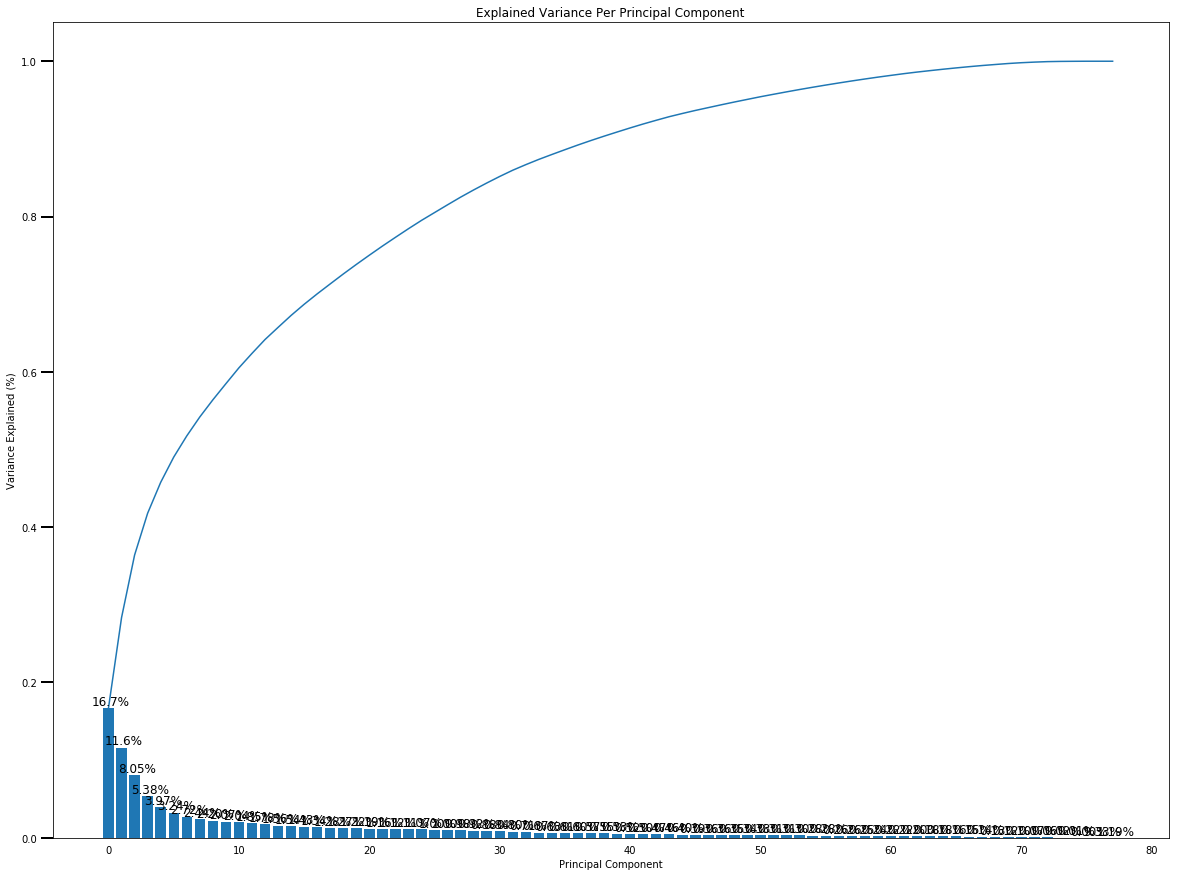

In [31]:
# Investigate the variance accounted for by each principal component.

def scree_plot(pca):
    '''
    Creates a scree plot associated with the principal components 
    
    INPUT: pca - the result of instantian of PCA in scikit learn
            
    OUTPUT:
            None
    '''
    num_components=len(pca.explained_variance_ratio_)
    ind = np.arange(num_components)
    vals = pca.explained_variance_ratio_
 
    plt.figure(figsize=(20, 15))
    ax = plt.subplot(111)
    cumvals = np.cumsum(vals)
    ax.bar(ind, vals)
    ax.plot(ind, cumvals)
    for i in range(num_components):
        ax.annotate(r"%s%%" % ((str(vals[i]*100)[:4])), (ind[i]+0.2, vals[i]), va="bottom", ha="center", fontsize=12)
 
    ax.xaxis.set_tick_params(width=0)
    ax.yaxis.set_tick_params(width=2, length=12)
 
    ax.set_xlabel("Principal Component")
    ax.set_ylabel("Variance Explained (%)")
    plt.title('Explained Variance Per Principal Component')
    
scree_plot(pca)

In [32]:
# number of components needed to explain at least 90% of the varience

for i in range(len(np.cumsum(pca.explained_variance_ratio_))):
    elem = np.cumsum(pca.explained_variance_ratio_).tolist()[i]
    comp_num = i+1
    if  elem >= 0.9:
        cum_sum = elem
        break
comp_num, cum_sum        

(39, 0.903489024770066)

In [33]:
# Re-apply PCA to the data while selecting for number of components to retain.

from sklearn.decomposition import PCA
'''
pca - the pca object created after fitting the data
general_pca - the transformed general_population_data matrix with new number of components
'''  
pca = PCA(n_components= 39, random_state=20)
general_pca = pca.fit_transform(general_population_data)

### Discussion 2.2: Perform Dimensionality Reduction

I chose only 39 PCA components which are the minimum needed to explain at least 90% of the varience.

### Step 2.3: Interpret Principal Components

Now that we have our transformed principal components, it's a nice idea to check out the weight of each variable on the first few components to see if they can be interpreted in some fashion.

As a reminder, each principal component is a unit vector that points in the direction of highest variance (after accounting for the variance captured by earlier principal components). The further a weight is from zero, the more the principal component is in the direction of the corresponding feature. If two features have large weights of the same sign (both positive or both negative), then increases in one tend expect to be associated with increases in the other. To contrast, features with different signs can be expected to show a negative correlation: increases in one variable should result in a decrease in the other.

-To investigate the features, we should map each weight to their corresponding feature name, then sort the features according to weight. The most interesting features for each principal component, then, will be those at the beginning and end of the sorted list.

In [34]:
# Map weights for the first principal component to corresponding feature names
# and then print the linked values, sorted by weight.
# HINT: Try defining a function here or in a new cell that we can reuse in the
# other cells.


def Mapping_weights_for_principal_component(n_comp, general_pca):
    '''
    Creates a dictionary of weights for a principal_component
    
    INPUT: number of components and the pca
            
    OUTPUT: dictionary of weights for a principal_component
    '''
    # for n in range(n_comp):
    pca_components_list = np.reshape(pca.components_[n_comp - 1], pca.components_[n_comp - 1].size).tolist()
    columns_list = general_population_data.columns.tolist()

    dict1 = dict(zip(columns_list, pca_components_list))
    dict1 = sorted(dict1.items(), key = lambda kv:(kv[1], kv[0]), reverse=True)
    
    
    return dict1


Mapping_weights_for_principal_component(1, pca)

[('HH_EINKOMMEN_SCORE', 0.20190107459169396),
 ('CAMEO_DEUG_2015', 0.20006495899453225),
 ('PLZ8_ANTG3', 0.19801478755398988),
 ('CAMEO_INTL_2015_WEALTH', 0.19684095848303929),
 ('PLZ8_ANTG4', 0.19092187463078583),
 ('ORTSGR_KLS9', 0.165946617149398),
 ('EWDICHTE', 0.16383200926479094),
 ('FINANZ_HAUSBAUER', 0.16201225617539539),
 ('KBA05_ANTG4', 0.14020865572447055),
 ('ZABEOTYP', 0.13575175897210826),
 ('PLZ8_ANTG2', 0.1346313609338907),
 ('KBA05_ANTG3', 0.129260728037777),
 ('ARBEIT', 0.1254152616671233),
 ('ANZ_HAUSHALTE_AKTIV', 0.12502418029955878),
 ('FINANZ_SPARER', 0.12367782684082781),
 ('RELAT_AB', 0.11643470886183963),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT_Mainstream', 0.10520166997890454),
 ('SEMIO_PFLICHT', 0.09228165597812878),
 ('SEMIO_REL', 0.08713490970485346),
 ('PRAEGENDE_JUGENDJAHRE_DECADE', 0.08407467119601195),
 ('SEMIO_RAT', 0.07767752650512504),
 ('GEBAEUDETYP', 0.06862162927376672),
 ('SEMIO_TRADV', 0.06755745115198761),
 ('GFK_URLAUBERTYP', 0.06226790801217242),
 

In [35]:
# Map weights for the second principal component to corresponding feature names
# and then print the linked values, sorted by weight.

Mapping_weights_for_principal_component(2, pca)

[('ALTERSKATEGORIE_GROB', 0.26025621458211334),
 ('FINANZ_VORSORGER', 0.23216458889966368),
 ('SEMIO_ERL', 0.22352945365452354),
 ('SEMIO_LUST', 0.18025627618018086),
 ('RETOURTYP_BK_S', 0.1613881478915971),
 ('W_KEIT_KIND_HH', 0.11829899350917651),
 ('FINANZTYP', 0.11407472870476476),
 ('SEMIO_KRIT', 0.1069574209393477),
 ('SHOPPER_TYP', 0.10464982331078224),
 ('FINANZ_HAUSBAUER', 0.10135014545645084),
 ('SEMIO_KAEM', 0.09725791267216694),
 ('FINANZ_MINIMALIST', 0.08211739799587557),
 ('ANREDE_KZ', 0.07785794846852534),
 ('PLZ8_ANTG3', 0.07326255422391983),
 ('PLZ8_ANTG4', 0.07108762592452875),
 ('EWDICHTE', 0.07074514081341741),
 ('ORTSGR_KLS9', 0.0700220082760693),
 ('CAMEO_INTL_2015_WEALTH', 0.06263990535582466),
 ('SEMIO_DOM', 0.05965599802847686),
 ('WOHNDAUER_2008', 0.05849193349806644),
 ('KBA05_ANTG4', 0.05835512491144137),
 ('CAMEO_DEUG_2015', 0.05796091830661384),
 ('ARBEIT', 0.056875792915007425),
 ('RELAT_AB', 0.05174439209438411),
 ('ANZ_HAUSHALTE_AKTIV', 0.05173193095980

In [36]:
# Map weights for the third principal component to corresponding feature names
# and then print the linked values, sorted by weight.

Mapping_weights_for_principal_component(3, pca)

[('SEMIO_VERT', 0.33586025465041874),
 ('SEMIO_SOZ', 0.26043782273447136),
 ('SEMIO_FAM', 0.25433642599237977),
 ('SEMIO_KULT', 0.2407624551893882),
 ('FINANZ_MINIMALIST', 0.14438500925157402),
 ('FINANZTYP', 0.11515896558545428),
 ('RETOURTYP_BK_S', 0.10060930308555877),
 ('SEMIO_REL', 0.08406059974458845),
 ('W_KEIT_KIND_HH', 0.08377840176316621),
 ('FINANZ_VORSORGER', 0.08333103664814691),
 ('SEMIO_MAT', 0.06501081170781493),
 ('ALTERSKATEGORIE_GROB', 0.0608784320708554),
 ('ORTSGR_KLS9', 0.055093857895958914),
 ('PLZ8_ANTG4', 0.05451092159609575),
 ('PLZ8_ANTG3', 0.05390369548764517),
 ('EWDICHTE', 0.052794733306053505),
 ('SEMIO_LUST', 0.050803949205298356),
 ('PRAEGENDE_JUGENDJAHRE_MOVEMENT_Avantgarde', 0.04795466516750863),
 ('GREEN_AVANTGARDE', 0.047954665167508626),
 ('ARBEIT', 0.04457115397145417),
 ('CAMEO_DEUG_2015', 0.03737457878851913),
 ('CAMEO_INTL_2015_WEALTH', 0.037173494137658684),
 ('RELAT_AB', 0.037169644405897644),
 ('PLZ8_ANTG2', 0.03462054314833351),
 ('KBA05_AN

### Discussion 2.3: Interpret Principal Components

- The first component has highest weights for 'ALTERSKATEGORIE_GROB', 'FINANZ_VORSORGER' and 'LP_STATUS_FEIN' which represents **Estimated household net income
, Wealth Typology and Social status**.
- Estimated household net income and Wealth Typology behaviour have positive correlation with each other and both have negative correlation with Social status because the order of the categories of Social status is reversed.
- The second component has the highest weights for 'ALTERSKATEGORIE_GROB' which is the **Estimated age**, and it also has a high weight for 'FINANZ_SPARER' which is **money-saver** behaviour.


## Step 3: Clustering

### Step 3.1: Apply Clustering to General Population

We've assessed and cleaned the demographics data, then scaled and transformed them. Now, it's time to see how the data clusters in the principal components space. In this substep, we will apply k-means clustering to the dataset and use the average within-cluster distances from each point to their assigned cluster's centroid to decide on a number of clusters to keep.

- Use sklearn's KMeans class to perform k-means clustering on the PCA-transformed data.
- Then, compute the average difference from each point to its assigned cluster's center.
- Perform the above two steps for a number of different cluster counts. we can then see how the average distance decreases with an increasing number of clusters. However, each additional cluster provides a smaller net benefit. Use this fact to select a final number of clusters in which to group the data.
- Once we've selected a final number of clusters to use, re-fit a KMeans instance to perform the clustering operation. Make sure that we also obtain the cluster assignments for the general demographics data, since we'll be using them in the final Step 3.3.

In [37]:
# get score list for clusters

from sklearn.cluster import KMeans

scores = []
centers= list(range(1,11,1))
for k in centers:
    kmeans_k = KMeans(n_clusters=k)
    model_k = kmeans_k.fit(general_pca)
    labels_k = np.abs(model_k.score(general_pca))
    scores.append(labels_k)

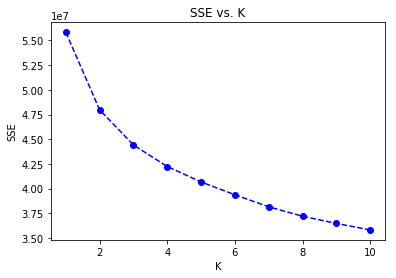

In [38]:
#plotting SSE vs number of clusters

plt.plot(centers, scores, linestyle='--', marker='o', color='b');
plt.xlabel('K');
plt.ylabel('SSE');
plt.title('SSE vs. K');

In [39]:
# KMeans for 7 clusters

from sklearn.cluster import KMeans

kmeans = KMeans(7, random_state=20)
general_k_model = kmeans.fit(general_pca)
general_label = general_k_model.predict(general_pca)

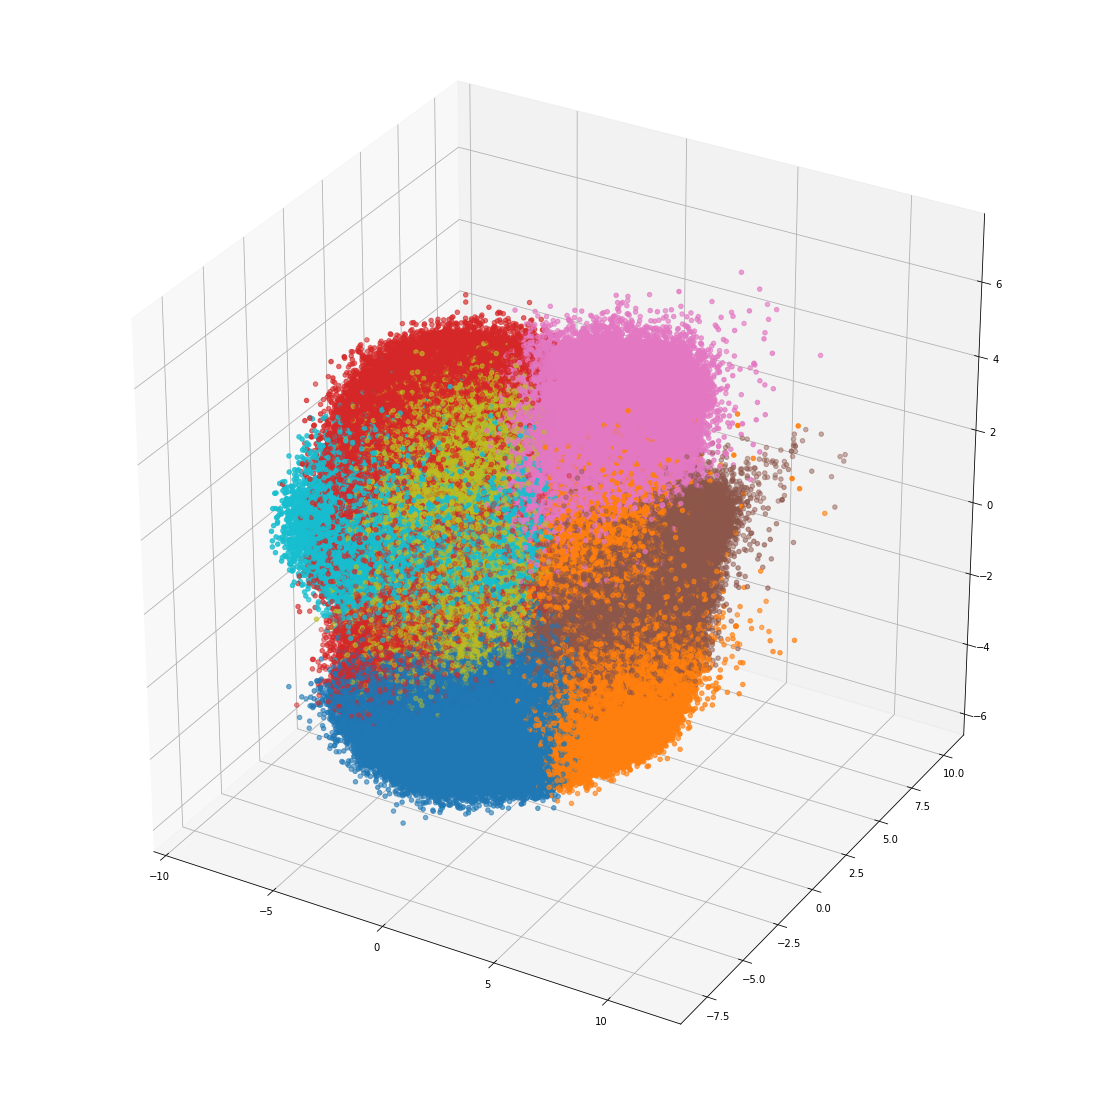

In [40]:
# plotting the 7 clusters

from mpl_toolkits.mplot3d import Axes3D

def plot_data(data, labels):
    '''
    Plot data with colors associated with labels
    '''
    fig = plt.figure(figsize = (15, 15));
    ax = Axes3D(fig)
    ax.scatter(data[:, 0], data[:, 1], data[:, 2], c=labels, cmap='tab10');
plot_data(general_pca, general_label)

### Discussion 3.1: Apply Clustering to General Population

There is no sharp elbow but when using 7 clusters the error is approximately settled

### Step 3.2: Apply All Steps to the Customer Data

Now that we have clusters and cluster centers for the general population, it's time to see how the customer data maps on to those clusters. Take care to not confuse this for re-fitting all of the models to the customer data. Instead, we're going to use the fits from the general population to clean, transform, and cluster the customer data. In the last step of the project, we will interpret how the general population fits apply to the customer data.

- Apply the same feature wrangling, selection, and engineering steps to the customer demographics using the `clean_data()` function we created earlier. (We can assume that the customer demographics data has similar meaning behind missing data patterns as the general demographics data.)
- Use the sklearn objects from the general demographics data, and apply their transformations to the customers data. That is, we should not be using a `.fit()` or `.fit_transform()` method to re-fit the old objects, nor should we be creating new sklearn objects! Carry the data through the feature scaling, PCA, and clustering steps, obtaining cluster assignments for all of the data in the customer demographics data.

In [41]:
# Load in the customer demographics data.
customers = pd.read_csv('Udacity_CUSTOMERS_Subset.csv', sep=';'  , engine='python')
customers.head()

,AGER_TYP,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,...,PLZ8_ANTG1,PLZ8_ANTG2,PLZ8_ANTG3,PLZ8_ANTG4,PLZ8_BAUMAX,PLZ8_HHZ,PLZ8_GBZ,ARBEIT,ORTSGR_KLS9,RELAT_AB
0,2,4,1,5.0,5,1,5,1,2,2,...,3.0,3.0,1.0,0.0,1.0,5.0,5.0,1.0,2.0,1.0
1,-1,4,1,NaN,5,1,5,1,3,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,-1,4,2,2.0,5,1,5,1,4,4,...,2.0,3.0,3.0,1.0,3.0,3.0,2.0,3.0,5.0,3.0
3,1,4,1,2.0,5,1,5,2,1,2,...,3.0,2.0,1.0,0.0,1.0,3.0,4.0,1.0,3.0,1.0
4,-1,3,1,6.0,3,1,4,4,5,2,...,2.0,4.0,2.0,1.0,2.0,3.0,3.0,3.0,5.0,1.0


In [42]:
# cleaning customers data
customers_cleaned, customer_column_list = clean_data(customers, high_null_column)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


In [43]:
# Apply feature scaling to the general population demographics data.

customers_cleaned[customer_column_list] = scaled.transform(customers_cleaned[customer_column_list])

In [44]:
# transforming customers data to pca components
customers_pca = pca.transform(customers_cleaned)

In [45]:
# predicting kmeans model for customers data
customers_label = general_k_model.predict(customers_pca)

### Step 3.3: Compare Customer Data to Demographics Data

At this point, we have clustered data based on demographics of the general population of Germany, and seen how the customer data for a mail-order sales company maps onto those demographic clusters. In this final substep, we will compare the two cluster distributions to see where the strongest customer base for the company is.

Consider the proportion of persons in each cluster for the general population, and the proportions for the customers. If we think the company's customer base to be universal, then the cluster assignment proportions should be fairly similar between the two. If there are only particular segments of the population that are interested in the company's products, then we should see a mismatch from one to the other. If there is a higher proportion of persons in a cluster for the customer data compared to the general population (e.g. 5% of persons are assigned to a cluster for the general population, but 15% of the customer data is closest to that cluster's centroid) then that suggests the people in that cluster to be a target audience for the company. On the other hand, the proportion of the data in a cluster being larger in the general population than the customer data (e.g. only 2% of customers closest to a population centroid that captures 6% of the data) suggests that group of persons to be outside of the target demographics.

Take a look at the following points in this step:

- Compute the proportion of data points in each cluster for the general population and the customer data. Visualizations will be useful here: both for the individual dataset proportions, but also to visualize the ratios in cluster representation between groups.
- Which cluster or clusters are overrepresented in the customer dataset compared to the general population? Select at least one such cluster and infer what kind of people might be represented by that cluster. Use the principal component interpretations from step 2.3 or look at additional components to help us make this inference. Alternatively, we can use the `.inverse_transform()` method of the StandardScaler object to transform centroids back to the original data space and interpret the retrieved values directly.
- Perform a similar investigation for the underrepresented clusters. Which cluster or clusters are underrepresented in the customer dataset compared to the general population, and what kinds of people are typified by these clusters?

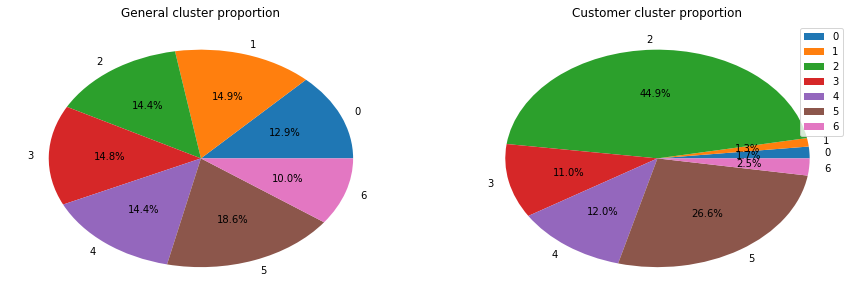

In [58]:
# plotting pie chart for general vs customers clusters proportion

general_cluster_dist = []
for cluster in range(7):
    general_cluster_dist.append((general_label == cluster).sum())

customers_cluster_dist = []
for cluster in range(7):
    customers_cluster_dist.append((customers_label == cluster).sum())


clusters = ["0", "1", "2", "3", "4", "5", "6"]

plt.figure(figsize= (15, 5))

plt.subplot(1, 2, 1)
plt.pie(general_cluster_dist, labels = clusters, autopct='%1.1f%%');
plt.title('General cluster proportion')
plt.subplot(1, 2, 2)
plt.pie(customers_cluster_dist, labels = clusters, autopct='%1.1f%%');
plt.title('Customer cluster proportion')

plt.legend();

From the charts we can see that **cluster 3** is overrepresented in the customers dataset and **cluster 6** is underrepresented.


In [59]:
# inverse_transformed general dataset
inverse_transformed_general = pd.DataFrame(scaled.inverse_transform(general_population_data), columns = column_list)
general_cluster_column = pd.DataFrame(general_label.tolist()).rename(columns={0: "Cluster"})

general_inverse_transformed = pd.concat([inverse_transformed_general, general_cluster_column], axis =1)
general_inverse_transformed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Avantgarde,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Mainstream,Cluster
0,1.0,2.0,5.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,5.0,4.0,0.0,1.0,9.0,5.0,1.0,2.775558e-17,1.0,1
1,3.0,2.0,3.0,1.0,4.0,1.0,2.0,3.0,5.0,1.0,...,5.0,2.0,0.0,1.0,9.0,2.0,4.0,1.000000e+00,0.0,0
2,4.0,2.0,2.0,4.0,2.0,5.0,2.0,1.0,2.0,6.0,...,3.0,3.0,0.0,1.0,7.0,1.0,2.0,2.775558e-17,1.0,5
3,3.0,1.0,5.0,4.0,3.0,4.0,1.0,3.0,2.0,5.0,...,6.0,5.0,0.0,1.0,7.0,4.0,3.0,2.775558e-17,1.0,4
4,1.0,2.0,2.0,3.0,1.0,5.0,2.0,2.0,5.0,2.0,...,3.0,3.0,0.0,1.0,5.0,5.0,4.0,2.775558e-17,1.0,0


In [60]:
# inverse_transformed customers dataset

inverse_transformed_customers = pd.DataFrame(scaled.inverse_transform(customers_cleaned), columns = customer_column_list)
customers_cluster_column = pd.DataFrame(customers_label.tolist()).rename(columns={0: "Cluster"})

customers_inverse_transformed = pd.concat([inverse_transformed_customers, customers_cluster_column], axis =1)
customers_inverse_transformed.head()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Avantgarde,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Mainstream,Cluster
0,4.0,1.0,5.0,5.0,1.0,5.0,1.0,2.0,2.0,2.0,...,2.0,1.0,0.0,1.0,5.0,1.0,3.0,1.000000e+00,0.0,2
1,4.0,2.0,2.0,5.0,1.0,5.0,1.0,4.0,4.0,2.0,...,5.0,3.0,0.0,1.0,5.0,3.0,4.0,1.000000e+00,0.0,2
2,4.0,1.0,2.0,5.0,1.0,5.0,2.0,1.0,2.0,6.0,...,3.0,1.0,0.0,1.0,4.0,2.0,4.0,2.775558e-17,1.0,5
3,3.0,1.0,6.0,3.0,1.0,4.0,4.0,5.0,2.0,2.0,...,5.0,1.0,0.0,1.0,7.0,4.0,1.0,2.775558e-17,1.0,4
4,3.0,1.0,4.0,5.0,1.0,5.0,1.0,2.0,3.0,5.0,...,7.0,5.0,0.0,1.0,5.0,3.0,4.0,1.000000e+00,0.0,2


In [61]:
# cluster 2 that is overrepresented in the customer data compared to the general population?
Cluster_2_general = general_inverse_transformed.query('Cluster == 2')

# cluster 1 that is underrepresented in the customer data compared to the general population?
Cluster_1_general = general_inverse_transformed.query('Cluster == 1')

In [62]:
# cluster 2 mode
Cluster_2_general.mode()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Avantgarde,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Mainstream,Cluster
0,3.0,1.0,2.0,5.0,1.0,5.0,1.0,2.0,1.0,6.0,...,5.0,3.0,0.0,1.0,7.0,1.0,4.0,1.0,0.0,2


In [63]:
# cluster 1 mode
Cluster_1_general.mode()

,ALTERSKATEGORIE_GROB,ANREDE_KZ,CJT_GESAMTTYP,FINANZ_MINIMALIST,FINANZ_SPARER,FINANZ_VORSORGER,FINANZ_ANLEGER,FINANZ_UNAUFFAELLIGER,FINANZ_HAUSBAUER,FINANZTYP,...,ORTSGR_KLS9,RELAT_AB,OST_WEST_KZ_O,OST_WEST_KZ_W,PRAEGENDE_JUGENDJAHRE_DECADE,CAMEO_INTL_2015_WEALTH,CAMEO_INTL_2015_LIFE_STAGE,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Avantgarde,PRAEGENDE_JUGENDJAHRE_MOVEMENT_Mainstream,Cluster
0,2.0,2.0,4.0,1.0,5.0,2.0,5.0,4.0,5.0,1.0,...,9.0,3.0,0.0,1.0,9.0,5.0,1.0,2.775558e-17,1.0,1


### Discussion 3.3: Compare Customer Data to Demographics Data

Now we can infer from cluster 6 that is overrepresented that the kind of people are:

- 46 - 60 years old
- Social status: top earners
- Insurance typology : individualistic-accepting risks
- very high money-saver
- very high investor

We can infer from cluster 1 that is underrepresented that the kind of people are:

- 30 - 45 years old
- Social status: low-income earners 
- very low money-saver
- very low investor

## References:

Udacity's helperfunctions.py (scree plot, plot_data for clusters and plotting SSE vs number of clusters)